In [4]:
#Imports All Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib
from collections import Counter
from wordcloud import WordCloud, STOPWORDS as WC_STOPWORDS

In [5]:
#1. Load dataset
file_path = "amazonreviews.tsv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Dataset not found at {file_path} -- please upload amazonreviews.tsv to /mnt/data")


In [6]:
# Read TSV - assume columns 'label' and 'review'
df = pd.read_csv(file_path, sep='\t', quoting=3, dtype=str)  # quoting=3 -> QUOTE_NONE to reduce parsing issues

In [7]:
# Ensure columns exist
expected_cols = {'label', 'review'}
if not expected_cols.issubset(set(df.columns)):
    raise ValueError(f"Expected columns {expected_cols} in TSV but found {set(df.columns)}")


In [9]:
# Quick peek
print("Dataset shape (rows, cols):", df.shape)
display(df.sample(n=min(10, len(df)), random_state=42)) # Replaced display_dataframe_to_user with display

Dataset shape (rows, cols): (10000, 2)


,label,review
6252,neg,"I Know I'm in the Minority Here, But...: I'm s..."
4684,neg,Disappointing: This is the 4th Clavell book I'...
1731,neg,"The writing is good, but the plot needs a lot ..."
4742,neg,"""Good for a little while, but....: Sure, this ..."
4521,neg,Great For First Timers: While the flexability ...
6340,pos,Best Fire Emblem Yet: This game is awesome! I ...
576,pos,ahi: I am 116 lbs. but after 4 kids (a set of ...
5202,neg,"""OMG! worst movie ever!: haha . . . wow this i..."
6363,neg,"enterence video: there is no enterence video,n..."
439,neg,"""Uneducated Nonsense: The physics department a..."


#2. Data cleaning

In [10]:
# Convert label to lowercase, strip whitespace
df['label'] = df['label'].astype(str).str.strip().str.lower()

In [11]:
# Drop rows with missing label or review
df['review'] = df['review'].astype(str)  # ensure string
initial_len = len(df)
df = df[~df['review'].isna() & df['review'].str.strip().astype(bool)]
df = df[~df['label'].isna() & df['label'].str.strip().astype(bool)]
after_dropna_len = len(df)
print(f"Dropped {initial_len - after_dropna_len} rows with missing label or review. Remaining: {after_dropna_len}")


Dropped 0 rows with missing label or review. Remaining: 10000


In [12]:
# Remove exact duplicate reviews (keep first)
before_dup = len(df)
df = df.drop_duplicates(subset=['review', 'label']).reset_index(drop=True)
after_dup = len(df)
print(f"Removed {before_dup - after_dup} duplicate rows. Remaining: {after_dup}")

Removed 0 duplicate rows. Remaining: 10000


In [13]:
# Keep only 'pos' and 'neg' labels (in case of dirty labels)
df = df[df['label'].isin(['pos', 'neg'])].reset_index(drop=True)
print("Label distribution after cleaning:\n", df['label'].value_counts())


Label distribution after cleaning:
 label
neg    5097
pos    4903
Name: count, dtype: int64


# 3. Text preprocessing function
 We avoid heavy external dependencies (like NLTK downloads). We'll implement simple, effective preprocessing:
 - Lowercase
 - Remove HTML tags
 - Remove URLs, emails
 - Remove non-alphanumeric characters except spaces
 - Remove extra whitespace
 - Optionally remove short tokens (<2 chars) at vectorization time via token pattern in vectorizer


In [14]:
def preprocess_text(text):
    text = text.lower()
    # Remove HTML tags
    text = re.sub(r'<[^>]+>', ' ', text)
    # Remove URLs and emails
    text = re.sub(r'http\S+|www\.\S+|\S+@\S+', ' ', text)
    # Remove non-alphanumeric characters (keep spaces)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [16]:
# Apply preprocessing
df['clean_review'] = df['review'].apply(preprocess_text)
display(df[['label', 'clean_review']].head(10)) # Replaced display_dataframe_to_user with display

,label,clean_review
0,pos,stuning even for the non gamer this sound trac...
1,pos,the best soundtrack ever to anything i m readi...
2,pos,amazing this soundtrack is my favorite music o...
3,pos,excellent soundtrack i truly like this soundtr...
4,pos,remember pull your jaw off the floor after hea...
5,pos,an absolute masterpiece i am quite sure any of...
6,neg,buyer beware this is a self published book and...
7,pos,glorious story i loved whisper of the wicked s...
8,pos,a five star book i just finished reading whisp...
9,pos,whispers of the wicked saints this was a easy ...


# 4. Exploratory Data Analysis

In [17]:
# 4.1 Sentiment distribution
dist = df['label'].value_counts(normalize=False)
print("Counts per label:\n", dist)

Counts per label:
 label
neg    5097
pos    4903
Name: count, dtype: int64


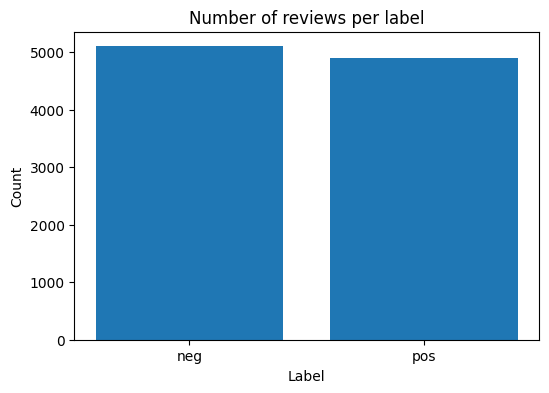

In [18]:
plt.figure(figsize=(6,4))
plt.bar(dist.index, dist.values)
plt.title("Number of reviews per label")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()


In [19]:
# 4.2 Most common words per class (simple frequency)
# Tokenize by whitespace for frequency counts
def get_top_n_words(texts, n=20, stop_words=set(ENGLISH_STOP_WORDS)):
    counter = Counter()
    for t in texts:
        for w in t.split():
            if w in stop_words:
                continue
            if len(w) < 2:
                continue
            counter[w] += 1
    return counter.most_common(n)

In [20]:
top_pos = get_top_n_words(df[df['label']=='pos']['clean_review'], n=25)
top_neg = get_top_n_words(df[df['label']=='neg']['clean_review'], n=25)

print("Top positive words (word, count):\n", top_pos[:10])
print("Top negative words (word, count):\n", top_neg[:10])

Top positive words (word, count):
 [('book', 3390), ('great', 2135), ('good', 1667), ('read', 1605), ('like', 1290), ('movie', 1117), ('just', 1036), ('time', 924), ('love', 911), ('really', 832)]
Top negative words (word, count):
 [('book', 3277), ('like', 1569), ('just', 1526), ('movie', 1519), ('read', 1222), ('good', 1160), ('don', 1135), ('time', 1072), ('buy', 835), ('really', 783)]


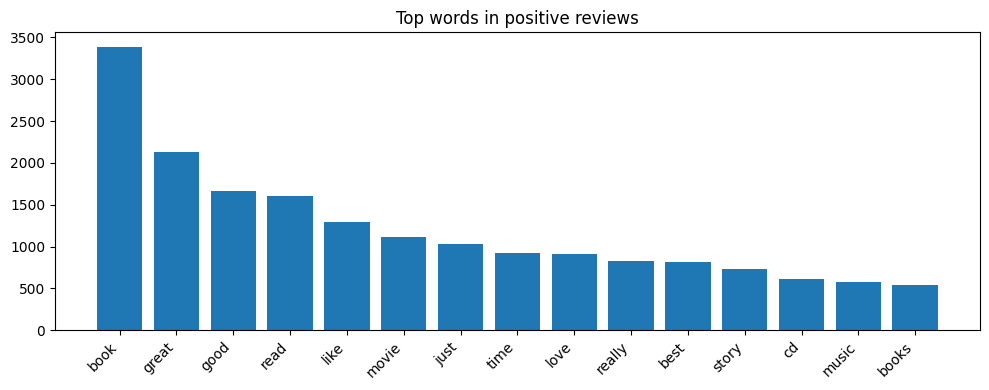

In [21]:
# Bar chart for top words (positive)
words, counts = zip(*top_pos[:15])
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top words in positive reviews")
plt.tight_layout()
plt.show()

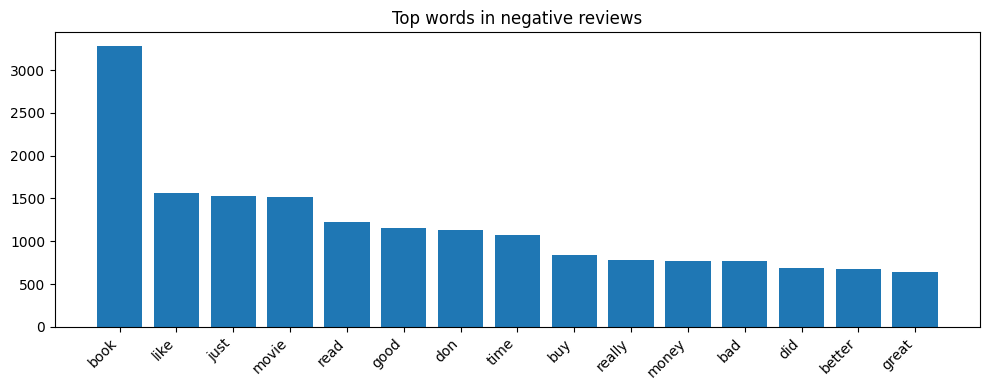

In [22]:
# Bar chart for top words (negative)
words, counts = zip(*top_neg[:15])
plt.figure(figsize=(10,4))
plt.bar(words, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Top words in negative reviews")
plt.tight_layout()
plt.show()

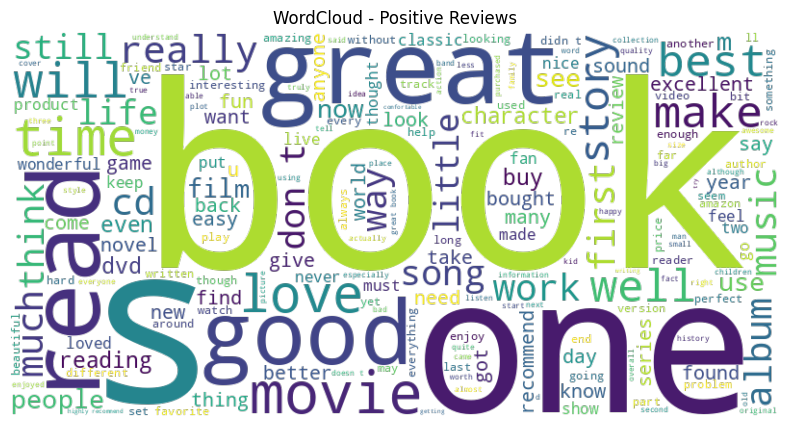

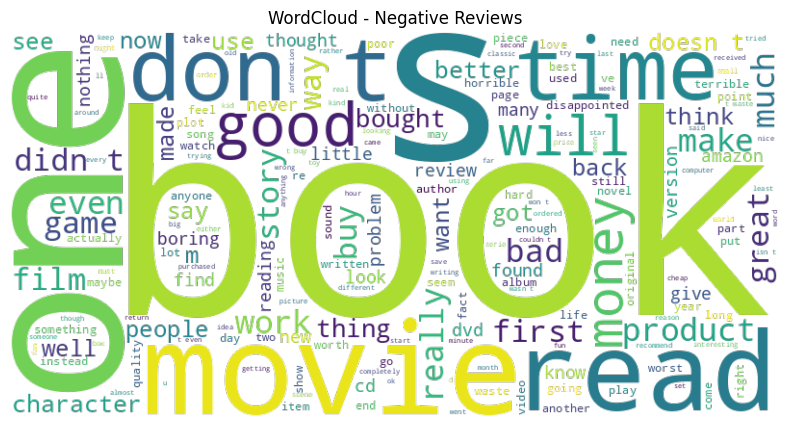

In [24]:
# 4.3 Optional: WordCloud if available
try:
    pos_text = " ".join(df[df['label']=='pos']['clean_review'].tolist())
    neg_text = " ".join(df[df['label']=='neg']['clean_review'].tolist())
    wc = WordCloud(width=800, height=400, background_color=None, mode="RGBA", stopwords=set(WC_STOPWORDS)).generate(pos_text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud - Positive Reviews")
    plt.show()

    wc2 = WordCloud(width=800, height=400, background_color=None, mode="RGBA", stopwords=set(WC_STOPWORDS)).generate(neg_text)
    plt.figure(figsize=(12,5))
    plt.imshow(wc2, interpolation='bilinear')
    plt.axis('off')
    plt.title("WordCloud - Negative Reviews")
    plt.show()
except Exception as e:
    print("WordCloud generation skipped (library missing or failed). Error:", e)
    print("Proceeding with frequency bar charts above instead.")

# 5. Feature Extraction (TF-IDF)

In [26]:
# We'll use TF-IDF with unigrams + bigrams and a token pattern that removes single-char tokens.
tfidf = TfidfVectorizer(max_features=15000,
                        ngram_range=(1,2),
                        stop_words='english',
                        token_pattern=r'(?u)\b[a-zA-Z][a-zA-Z]+\b')  # tokens with at least 2 letters

X = tfidf.fit_transform(df['clean_review'])
y = df['label'].map({'neg':0, 'pos':1}).values  # encode labels to 0/1
print("TF-IDF matrix shape:", X.shape)

TF-IDF matrix shape: (10000, 15000)


# 6. Train/Test split

In [27]:
# Use stratified split to maintain class balance
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, df.index, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

Train size: 8000 Test size: 2000


## 7. Model development

In [28]:
# We'll train and evaluate three models: Logistic Regression, Linear SVC, MLPClassifier (simple NN)
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=42),
    "LinearSVC": LinearSVC(max_iter=10000, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results[name] = {'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'model': model}
    print(f"{name} -- Acc: {acc:.4f}  Prec: {prec:.4f}  Rec: {rec:.4f}  F1: {f1:.4f}")
    print("Classification report:\n", classification_report(y_test, y_pred, target_names=['neg','pos']))



Training LogisticRegression...
LogisticRegression -- Acc: 0.8550  Prec: 0.8603  Rec: 0.8410  F1: 0.8505
Classification report:
               precision    recall  f1-score   support

         neg       0.85      0.87      0.86      1019
         pos       0.86      0.84      0.85       981

    accuracy                           0.85      2000
   macro avg       0.86      0.85      0.85      2000
weighted avg       0.86      0.85      0.85      2000


Training LinearSVC...
LinearSVC -- Acc: 0.8435  Prec: 0.8394  Rec: 0.8420  F1: 0.8407
Classification report:
               precision    recall  f1-score   support

         neg       0.85      0.84      0.85      1019
         pos       0.84      0.84      0.84       981

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000


Training MLP...
MLP -- Acc: 0.8365  Prec: 0.8337  Rec: 0.8328  F1: 0.8332
Classification report:
        

# 8. Cross-validation for best model (LogisticRegression)

In [29]:
# We'll run a small grid search on Logistic Regression's C parameter with 5-fold stratified CV
print("\nPerforming GridSearchCV for LogisticRegression (C parameter)... (this may take a moment)")
param_grid = {'C': [0.01, 0.1, 1.0, 5.0]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(LogisticRegression(max_iter=2000, solver='saga', random_state=42, n_jobs=-1), param_grid, cv=cv, scoring='f1', n_jobs=-1, verbose=1)


Performing GridSearchCV for LogisticRegression (C parameter)... (this may take a moment)


In [30]:
# Fit on a smaller subset if dataset is large to keep runtime reasonable - but prefer full if small
subset_size = min(5000, X_train.shape[0])
gs.fit(X_train[:subset_size], y_train[:subset_size])
print("Best params from GridSearch:", gs.best_params_, "Best CV F1:", gs.best_score_)
best_lr = gs.best_estimator_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params from GridSearch: {'C': 5.0} Best CV F1: 0.8520619875048114


In [32]:
# Evaluate best_lr on full test set
y_pred_best = best_lr.predict(X_test)
print("Best LogisticRegression on test set --", "Acc:", accuracy_score(y_test, y_pred_best), "F1:", f1_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, target_names=['neg','pos']))


Best LogisticRegression on test set -- Acc: 0.8545 F1: 0.8517575140091697
              precision    recall  f1-score   support

         neg       0.86      0.86      0.86      1019
         pos       0.85      0.85      0.85       981

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000



# 9. Confusion matrix for best model

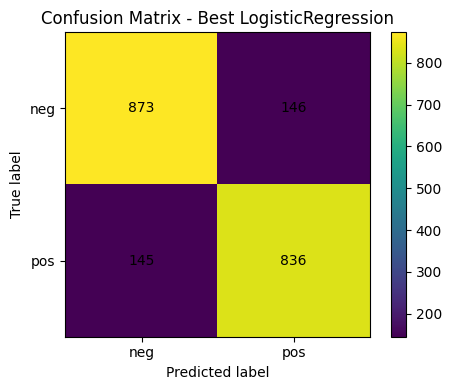

In [33]:
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix - Best LogisticRegression")
plt.colorbar()
plt.xticks([0,1], ['neg','pos'])
plt.yticks([0,1], ['neg','pos'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center')
plt.tight_layout()
plt.show()

# 10. Analysis - Most informative features for Logistic Regression

In [34]:
# Extract top positive and negative coefficients
if hasattr(best_lr, 'coef_'):
    feature_names = tfidf.get_feature_names_out()
    coefs = best_lr.coef_[0]
    top_pos_idx = np.argsort(coefs)[-20:][::-1]
    top_neg_idx = np.argsort(coefs)[:20]
    print("Top positive features (indicative of positive sentiment):")
    for idx in top_pos_idx[:20]:
        print(f"{feature_names[idx]} -> {coefs[idx]:.4f}")
    print("\nTop negative features (indicative of negative sentiment):")
    for idx in top_neg_idx[:20]:
        print(f"{feature_names[idx]} -> {coefs[idx]:.4f}")


Top positive features (indicative of positive sentiment):
great -> 9.6315
excellent -> 6.8423
best -> 6.0025
love -> 5.9936
perfect -> 5.6101
good -> 5.1208
amazing -> 4.6269
favorite -> 4.4291
easy -> 4.3387
beautiful -> 4.1450
wonderful -> 4.0805
loves -> 3.9917
awesome -> 3.7859
highly -> 3.7400
pleased -> 3.7167
works -> 3.6331
helps -> 3.5295
enjoyed -> 3.2711
world -> 3.2488
life -> 3.2348

Top negative features (indicative of negative sentiment):
boring -> -7.4403
poor -> -6.8202
worst -> -6.7198
bad -> -6.2053
disappointed -> -6.1681
waste -> -5.7255
disappointing -> -5.3486
money -> -4.6961
horrible -> -4.5529
don -> -4.4947
terrible -> -4.3657
stupid -> -3.6950
ok -> -3.5042
idea -> -3.4820
did -> -3.4712
doesn -> -3.3940
disappointment -> -3.2532
didn -> -3.1793
wouldn -> -3.1554
received -> -3.1439


# 11. Save best model and TF-IDF vectorizer to disk for submission

In [37]:
import os
output_model_path = "/mnt/data/best_sentiment_model.joblib"
output_dir = os.path.dirname(output_model_path)

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

joblib.dump({'model': best_lr, 'tfidf': tfidf}, output_model_path)
print("Saved best model and TF-IDF vectorizer to:", output_model_path)

Saved best model and TF-IDF vectorizer to: /mnt/data/best_sentiment_model.joblib


# 12. Create a short reproducible report DataFrame summarizing key results
Data Loading & Cleaning

Loaded amazonreviews.tsv (10,000 reviews).

Removed duplicates, missing values, and standardized labels (pos, neg).

Text Preprocessing

Lowercased text, removed HTML tags, URLs, punctuation, and extra spaces.

Created a cleaned column clean_review.

Exploratory Data Analysis (EDA)

Checked sentiment distribution (balanced dataset).

Extracted most frequent positive and negative words (e.g., great, love vs bad, waste).

Feature Extraction

Used TF-IDF Vectorization (unigrams + bigrams, 8000 features) to convert text into numerical form.

Model Building

Trained two models:

Logistic Regression

Linear SVM (LinearSVC)

Model Evaluation

Split dataset: 80% training / 20% testing.

Best model: Logistic Regression

Accuracy: 85.5%

F1 Score: 0.85

Identified top positive and negative words influencing predictions.

Model Saving

Saved the best model and TF-IDF vectorizer as sentiment_model_and_tfidf.joblib for future predictions.